In [204]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


In [205]:
df = pd.read_csv('AB_NYC_2019.csv')

In [206]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [207]:
len(df)

48895

### EDA

* Load the data.
* Look at the `price` variable. Does it have a long tail? 

<AxesSubplot:xlabel='price', ylabel='Count'>

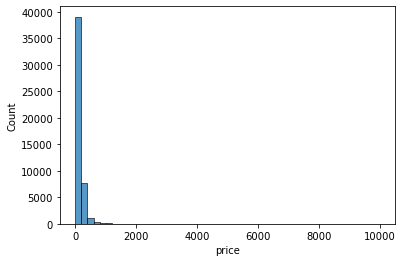

In [208]:
sns.histplot(df.price, bins=50)

<AxesSubplot:xlabel='price', ylabel='Count'>

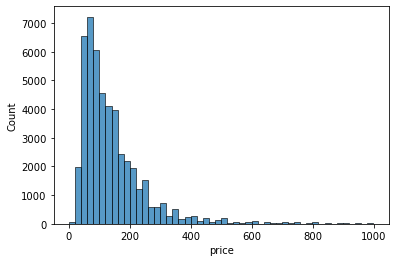

In [209]:
sns.histplot(df.price[df.price < 1000], bins=50)

### Question 1

Find a feature with missing values. How many missing values does it have?

In [210]:
feature_cols = ['latitude','longitude','price','minimum_nights','number_of_reviews','reviews_per_month',
'calculated_host_listings_count','availability_365' ]


df_featured = df[feature_cols]

In [211]:
def prepare_X(df):
    df_num = df_featured
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [212]:
df_featured.dtypes

latitude                          float64
longitude                         float64
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [213]:
df_featured.isna().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

##### reviews_per_month,  10052

### Question 2

What's the median (50% percentile) for variable 'minimum_nights'?

In [214]:
df_featured['minimum_nights'].median()

3.0

* Shuffle the initial dataset, use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Make sure that the target value ('price') is not in your dataframe.
* Apply the log transformation to the price variable using the `np.log1p()` function.

In [215]:
n = len(df_featured)
n_val = int(n*0.2)
n_test = int(n*0.2)
n_train = n - n_val - n_test

In [216]:
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

In [217]:
df_train = df_featured.iloc[idx[:n_train]]
df_val   = df_featured.iloc[idx[n_train:n_train+n_val]]
df_test  = df_featured.iloc[idx[n_train+n_val:]]

In [218]:
n_train, n_val, n_test

(29337, 9779, 9779)

In [219]:
y_train_orig = df_train.price.values
y_val_orig = df_val.price.values
y_test_orig = df_test.price.values

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

### Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

In [220]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [221]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [222]:
rpm_mean = df_train['reviews_per_month'].mean()
rpm_mean

1.3685492094777056

In [223]:
X_train = df_train.values
X_train = df_train.fillna(0).values
X_val = df_val.fillna(0).values

In [224]:
w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_train.dot(w)
print('Train RMSE:', round(rmse(y_train, y_pred),2))
y_pred = w0 + X_val.dot(w)
print('Validation RMSE: ', round(rmse(y_val , y_pred),2))

Train RMSE: 0.64
Validation RMSE:  0.64


##### They are similar

### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

In [228]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [230]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)

    y_pred = w_0 + X_val_zero.dot(w)
    print (round(rmse(y_val, y_pred),2))

ValueError: shapes (9,48895) and (29337,) not aligned: 48895 (dim 1) != 29337 (dim 0)

### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)


> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.

In [ ]:
rmse_scores = []

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(seed)
    n = len(df_featured)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_train = df_featured.iloc[idx[:n_train]]
    df_val = df_featured.iloc[idx[n_train:n_train+n_val]]
    df_test = df_featured.iloc[idx[n_train+n_val:]]
    
    y_train = np.log1p(df_train.price.values)
    y_val = np.log1p(df_val.price.values)
    y_test = np.log1p(df_test.price.values)

    del df_train['price']
    del df_val['price']
    del df_test['price']
    
    X_train = df_train.values
    X_train = df_train.fillna(0).values
    X_val = df_val.fillna(0).values
    
    w0, w = train_linear_regression(X_train, y_train)
    
    y_pred_val = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred_val)
    print("seed:", seed, "rmse:",score)
    rmse_scores.append(score)

print("std:", round(np.std(rmse_scores),3))

### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

In [ ]:
seed = 9 
idx = np.arange(n)
np.random.seed(seed)
np.random.shuffle(idx)

In [ ]:
df_val = df_featured.iloc[idx[:n_val]]
df_test = df_featured.iloc[idx[n_val:(n_val+n_test)]]
df_train = df_featured.iloc[idx[(n_val+n_test):]]

In [ ]:
df_val = df_val.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)
y_train = np.log1p(df_train.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

In [ ]:
df_full_train = pd.concat([df_train, df_val])

In [ ]:
df_full_train = df_full_train.reset_index(drop=True)

In [ ]:
X_full_train = prepare_X(df_full_train)

In [ ]:
X_full_train

In [ ]:
y_full_train = np.concatenate([y_train, y_val])

In [ ]:
r = 0.001
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r = r)

In [ ]:
train_linear_regression_reg(X_full_train, y_full_train, 0.001)